<a href="https://colab.research.google.com/github/michel-vbarboza/ERA5-Temperature-Prediction/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path for files on Google Drive
path = '/content/drive/MyDrive/MMEAD Dissertacao/Dados/'

In [ ]:
# Install and load libraries
!pip install netCDF4 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.2 MB/s eta 0:00:00


In [ ]:
import xarray as xr
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load NetCDF files
NetCDF files spanning each month from 2010 to 2019 are available. The code below iterates through each period, merging them into a unified dataframe.

In [ ]:
df = pd.DataFrame()

# Open all files, convert to dataframe and concatenate in a single dataframe
for year in range(2010, 2020):
    for month in range(1, 13):
      file_name = path+'download-'+str(year)+'-'+str(month)+'.nc'
      ds_temp = xr.open_dataset(file_name)
      df_temp = ds_temp.to_dataframe()
      df = pd.concat([df, df_temp])

del ds_temp, df_temp, month, year

# Encode Categorical Variables

The categorical variables 'ptype' and 'slt' have been converted into dummy variables. To prevent multicollinearity, the first category of each variable has been dropped.

In [ ]:
categ_vars = ['ptype', 'slt']

df[categ_vars] = df[categ_vars].round().astype(int)

df = pd.get_dummies(df, columns=categ_vars, drop_first=True, dtype=int)

# List of DFs by Geographic Coordinates

The dataframe was split into a list of smaller dataframes, with each dataframe corresponding to a unique combination of longitude and latitude. This approach simplifies preprocessing.

In [ ]:
# Unique longitudes and latitudes
unique_longitudes = df.index.get_level_values('longitude').unique()
unique_latitudes = df.index.get_level_values('latitude').unique()

In [ ]:
list_dfs = []

for lon in unique_longitudes:
    for lat in unique_latitudes:
        subset_df = df.loc[(lon, lat), :].copy()
        subset_df['longitude'] = lon
        subset_df['latitude'] = lat
        list_dfs.append(subset_df)

del df, subset_df, lon, lat

# Feature Engineering


* The cyclical features were transformed using sine and cosine functions to maintain the inherent cyclical nature of time.
* A 15-day rolling average of temperature was computed for each observation, smoothing out short-term fluctuations and highlighting long-term trends and seasonal patterns.
* 24-hour rolling maximum and minimum temperature were calculated for each observation to capture daily peaks and lows.
* For all computable features, 24-hour and 6-hour lagged values were generated, along with their differences. These features help in understanding how past conditions influence future outcomes and in detecting abrupt temperature shifts.


In [ ]:
# Calculable features
features_calc = ['u10', 'v10', 'd2m', 't2m', 'e', 'hcc',
                 'lcc', 'ro', 'ssr', 'str', 'sp', 'tp']

def feature_engineering(df, features):
    # Make a copy of the DataFrame to avoid modifying the original
    _df = df.copy()

    # Features from time
    _df['year'] = _df.index.year

    # Sine/Cosine transformation for cyclic features (hour of the day)
    _df['hour_sin'] = np.sin(2 * np.pi * _df.index.hour / 24)
    _df['hour_cos'] = np.cos(2 * np.pi * _df.index.hour / 24)

    # Sine/Cosine transformation for cyclic features (weak of the year)
    _df['week_sin'] = np.sin(2 * np.pi * _df.index.isocalendar().week / 24)
    _df['week_cos'] = np.cos(2 * np.pi * _df.index.isocalendar().week / 24)

    # Sine/Cosine transformation for cyclic features (month of the year)
    _df['month_sin'] = np.sin(2 * np.pi * _df.index.month / 12)
    _df['month_cos'] = np.cos(2 * np.pi * _df.index.month / 12)

    # Rolling average 't2m' last 15 days
    _df['15d_rolling_t2m_avg'] = _df['t2m'].rolling(window='15D').mean()

    # Rolling maximun and minimun 't2m' value from last 24h
    _df[f'24h_rolling_t2m_max'] = _df['t2m'].rolling(window=24).max()
    _df[f'24h_rolling_t2m_min'] = _df['t2m'].rolling(window=24).min()

    # Lagged value and difference between the current value and the value
    # from the previous day for all computable variables
    for feat in features:
        _df[f'lagged_24h_{feat}'] = _df[feat].shift(periods=24)
        _df[f'diff_24h_{feat}'] = _df[feat].diff(periods=24)
        _df[f'lagged_6h_{feat}'] = _df[feat].shift(periods=6)
        _df[f'diff_6h_{feat}'] = _df[feat].diff(periods=6)


    # Remove 15 first days - NAs generated due to rolling average calculation
    _df = _df.iloc[15 * 24:]

    return _df

In [ ]:
# Apply the function to every DataFrame in the list using a list comprehension
list_dfs = [feature_engineering(df, features_calc) for df in list_dfs]

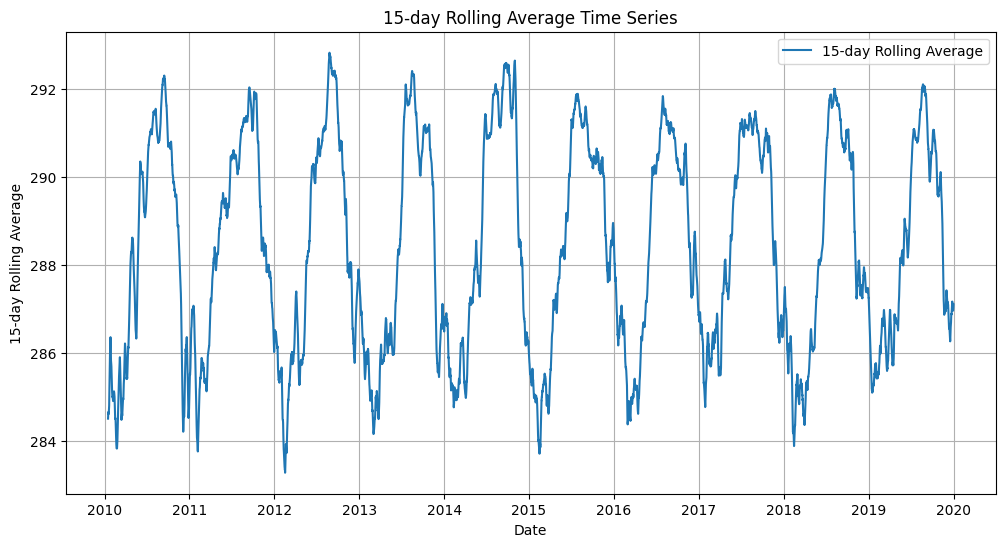

In [ ]:
# Plot of rolling average

import matplotlib.pyplot as plt

df_0 = list_dfs[0]

# Plot the '7d_rolling_avg' time series
plt.figure(figsize=(12, 6))
plt.plot(df_0.index, df_0['15d_rolling_t2m_avg'], label='15-day Rolling Average',)

# Add titles and labels
plt.title('15-day Rolling Average Time Series')
plt.xlabel('Date')
plt.ylabel('15-day Rolling Average')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Filter Maximum Temperature by Day

In [ ]:
def get_max(df):
  # Make a copy of the DataFrame to avoid modifying the original
  _df = df.copy()

  # Group by day and get the index of max 't2m' for each day
  idx_max = _df.groupby(pd.Grouper(freq='D'))['t2m'].idxmax()

  # Retrieve the corresponding rows from the original DataFrame
  df_max = _df.loc[idx_max]

  # Reset the index and convert time index format to yyyy-mm-dd
  df_max.index = df_max.index.strftime('%Y-%m-%d')
  df_max.index = pd.DatetimeIndex(df_max.index)

  return df_max

In [ ]:
# Filter daily max
list_dfs = [get_max(df) for df in list_dfs]

# Targets Creation
**Targets created:** 1, 3, 5, 7, 10, 15 days after current observation.

In [ ]:
target_periods = [1, 3, 5, 7, 10, 15]

def create_targets_hour(df, target_periods):
    # Make a copy of the DataFrame to avoid modifying the original
    _df = df.copy()

    # Create targets
    for period in target_periods:
      _df[f'target_{period}'] = _df['t2m'].shift(periods=-period, freq='D')

    # Remove last 15 days - NAs generated due to shift
    _df = _df.iloc[:-360]

    return _df



# Targets for daily dataframe
def create_targets_day(df, target_periods):
    # Make a copy of the DataFrame to avoid modifying the original
    _df = df.copy()

    # Create targets
    for period in target_periods:
      _df[f'target_{period}'] = _df['t2m'].shift(periods=-period, freq='D')

    # Remove last 15 days - NAs generated due to shift
    _df = _df.iloc[:-15]

    return _df

In [ ]:
# Apply the function to every DataFrame in the list using a list comprehension
list_dfs = [create_targets_day(df, target_periods) for df in list_dfs]

# Scale numeric variables

In [ ]:
scaler = StandardScaler()

targets = ['target_1', 'target_3', 'target_5',
           'target_7', 'target_10', 'target_15']

categ_vars = ['ptype_1', 'ptype_3', 'ptype_5', 'ptype_6', 'ptype_7', 'ptype_8',
              'slt_1', 'slt_2', 'slt_3', 'slt_4']

def scale_and_split(df):
    _df = df.copy()

    # Select features to scale (excluding targets)
    feat_scale = _df.columns.difference(targets+categ_vars)

    # Scale features
    _df[feat_scale] = scaler.fit_transform(_df[feat_scale])


    # Split train-test
    train = _df[_df.index.year < 2018]
    test = _df[_df.index.year >= 2018]

    return train, test

In [ ]:
list_train, list_test = zip(*[scale_and_split(df) for df in list_dfs])

# Dump Lists and DataFrames as Pickle

In [ ]:
# Save list of dfs with geographic coordinates
list_geo_coord = [df[['longitude', 'latitude']] for df in list_dfs]
with open(path+'list_geo_coord.pkl', 'wb') as f:
    pickle.dump(list_geo_coord, f)

list_geo_coord_test = [df[['longitude', 'latitude']] for df in list_test]
with open(path+'list_geo_coord_test.pkl', 'wb') as f:
    pickle.dump(list_geo_coord_test, f)

del f, list_geo_coord, list_geo_coord_test

In [ ]:
# Save the list of dataframes using pickle
with open(path+'list_train.pkl', 'wb') as f:
    pickle.dump(list_train, f)

with open(path+'list_test.pkl', 'wb') as f:
    pickle.dump(list_test, f)

del f

In [ ]:
# Concatenate list of dataframes
train = pd.concat(list_train)
test = pd.concat(list_test)

In [ ]:
# Save concatenated dataframes using pickle
with open(path+'train.pkl', 'wb') as f:
    pickle.dump(train, f)

with open(path+'test.pkl', 'wb') as f:
    pickle.dump(test, f)

del f, list_train, list_test

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 854658 entries, 2010-01-16 to 2017-12-31
Data columns (total 91 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   u10                  854658 non-null  float64
 1   v10                  854658 non-null  float64
 2   d2m                  854658 non-null  float64
 3   t2m                  854658 non-null  float64
 4   e                    854658 non-null  float64
 5   hcc                  854658 non-null  float64
 6   cvh                  854658 non-null  float64
 7   cl                   854658 non-null  float64
 8   lcc                  854658 non-null  float64
 9   cvl                  854658 non-null  float64
 10  ro                   854658 non-null  float64
 11  ssr                  854658 non-null  float64
 12  str                  854658 non-null  float64
 13  sp                   854658 non-null  float64
 14  tp                   854658 non-null  float64
 15  p